<a href="https://colab.research.google.com/github/AlMarNeuro/AlMarNR/blob/media108/Stajirovka_Media108_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Содержание основных разделов ноутбука

## Инициализация

In [ ]:
# Подключение google-диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#
# Загрузка библиотек
#
import os # Работа с файловой системой
import time # Работа с системным временем
import pickle as pkl # Сериализация данных
import pandas as pd # Датафреймы
# Параметры отображения датафреймов
pd.options.display.max_rows     = 99
pd.options.display.max_colwidth = 999
import numpy as np
import regex as re
import librosa # Для параметризации аудио
import librosa.display # Для отображения аудио сигналов
import matplotlib.pyplot as plt # Для отрисовки графиков
plt.style.use('dark_background')
from google.colab import files # Для загрузки файлов
import IPython.display as ipd # Для проигрывания аудио
from IPython.display import Audio
import seaborn as sns
###
# Подготовка данных
import sklearn # Для нормирования
from sklearn.preprocessing import LabelEncoder, StandardScaler # Масштабирование, нормировка данных
from sklearn.model_selection import train_test_split # Разбиение на обучающую и проверочную выборку

# Функции-утилиты для работы с категориальными данными
from keras.api._v2.keras import utils
from keras.api._v2.keras.utils import to_categorical

# Класс для конструирования последовательной модели нейронной сети
from keras.api._v2.keras.models import Sequential, Model

# Основные слои
from keras.api._v2.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from keras.api._v2.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, Conv2D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from keras.api._v2.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразования текстов в последовательности
from keras.api._v2.keras.preprocessing.text import Tokenizer

%matplotlib inline

In [ ]:
#
# Глобальные переменные
#
VM_CNT = '/content'
VM_CNT_DRV = VM_CNT + '/drive'
MY_CNT = '/content/drive/MyDrive/УИИ(marphida)/Стажировка_Media108'

WAV_PATH = VM_CNT_DRV + '/MyDrive/УИИ(marphida)/Стажировка_Media108/Audio/'
WAV_FILE = '2023-07-16_19-33-07.854622_from_79254254955_to_0111642_session_3091299879_talk.wav'
WAV_DATA = WAV_PATH + WAV_FILE

WAV_PRIMA = MY_CNT + '/Audio/Записи звонков_primavera/'
WAV_PAVEL_ST = MY_CNT + '/Audio/Записи звонков_павелецкая сити'
WAV_PAVEL_HL = MY_CNT + '/Audio/Записи звонков_хедлайнер'
WAV_ZV_INFO = MY_CNT + '/Audio/Информация о звонках'

DF_HL = MY_CNT + '/РГ/Headliner_df.pkl'
DF_PAVEL_ST = MY_CNT + '/РГ/Paveletskaya_city_df.pkl'
DF_PAVEL_HL = MY_CNT + '/РГ/Paveletskaya_df.pkl'
DF_PRIMA = MY_CNT + '/РГ/Primavera_df.pkl'
DF_TOTAL = MY_CNT + '/РГ/total_df.pkl'
DF_TOTAL_MATCH = MY_CNT + '/РГ/total_match_df.pkl'
DF_TOTAL_NOT_MATCH = MY_CNT + '/РГ/total_not_match_df.pkl'

CSV_HL = MY_CNT + '/РП/Headliner_with_audio.csv'
CSV_PST = MY_CNT + '/РП/Павелецкая_ЖК_«Павелецкая_сити»_with_audio.csv'
CSV_PTB = MY_CNT + '/РП/Paveleckaya_with_audio.csv'
CSV_PRM = MY_CNT + '/РП/Primavera_with_audio.csv'

DUMP = '/content/drive/MyDrive/УИИ(marphida)/Стажировка_Media108/DataDump'

# Параметры предобработки аудиосигнала и подготовки обучающих выборок
LEN_MEAN_AU = 10       # Шаг усреднения аудио
LEN_CONV1D_AU = 1000  # Размер окна одномерной свёртки аудио
STEP_CONV1D_AU = 100  # Шаг сдвига по свёртке аудио

AU_OHE_CLASSES = 100

## Хранилища датафреймов


### CSV Романа

In [ ]:
# Headliner
df_hl = pd.read_csv(CSV_HL)
print(f'df_hl.shape = {df_hl.shape}')
# Paveletskaya_city
df_pst = pd.read_csv(CSV_PST)
print(f'df_pst.shape = {df_pst.shape}')
# Paveletskaya_turbo
df_ptb = pd.read_csv(CSV_PTB)
print(f'df_ptb.shape = {df_ptb.shape}')
# Primavera
df_pri = pd.read_csv(CSV_PRM)
print(f'df_pri.shape = {df_pri.shape}')

df_hl.shape = (2045, 73)
df_pst.shape = (1000, 76)
df_ptb.shape = (1784, 76)
df_pri.shape = (1517, 75)


In [ ]:
del df_hl, df_pst, df_ptb, df_pri

In [ ]:
df_hl['Теги'].unique().tolist()

['Первичный целевой - 3 очередь - 1-ком',
 'спорный - нет соединения',
 'спорный - номер взят не дозвонились  до ОП',
 'постпродажное обслуживание - Условно целевой - Б.хаус',
 'спорный - клиент просил перезвонить',
 'постпродажное обслуживание - i love - Условно целевой',
 'повторная покупка - Вторичный целевой - 2 очередь - 1-ком',
 'Первичный целевой - 2 очередь - 3 очередь - 2-ком',
 'Лид - не проходит по бюджету - 3 очередь - Условно целевой - 1-ком',
 '3 очередь - 2-ком - Условно целевой',
 'спорный - связь прервалась',
 'Первичный целевой - студия - 3 очередь',
 'Нецелевой звонок - сотрудничество',
 'тест',
 'Вторичный целевой - 2 очередь - 2-ком - балкон - 3-ком',
 'Первичный целевой - ипотека - студия - 3 очередь',
 'повторная покупка - Вторичный целевой - 2 очередь - 3 очередь - 1-ком',
 'Нецелевой звонок - ошибка',
 'i love - 2-ком - Условно целевой',
 'интересуют скидки - Первичный целевой - 1 очередь - 2-ком',
 'постпродажное обслуживание - Вторичный целевой',
 'Первичный 

In [ ]:
df_hl['Аудиофайл']

0       2023-07-19_17-12-58.258412_from_79991345109_to_74959339902_session_3099072526_talk.mp3
1           2023-07-19_17-11-07.982207_from_79991345109_to_0188880_session_3098403244_talk.mp3
2       2023-07-19_17-01-54.812316_from_79835094068_to_74959339902_session_3099032036_talk.mp3
3       2023-07-19_16-52-13.751207_from_79152403560_to_74959339929_session_3099003691_talk.mp3
4       2023-07-19_16-51-00.801138_from_79161024742_to_74959339902_session_3098339039_talk.mp3
                                                 ...                                          
2040        2023-05-08_12-51-38.868213_from_74997040921_to_0188880_session_2928283255_talk.mp3
2041        2023-05-08_12-35-55.567230_from_79622801999_to_0188880_session_2938080128_talk.mp3
2042        2023-05-08_12-34-46.730988_from_79622801999_to_0188880_session_2928807121_talk.mp3
2043        2023-05-08_11-43-52.513973_from_79827693228_to_0188880_session_2937971588_talk.mp3
2044    2023-05-08_10-41-56.911054_from_7925081717

### Датафреймы Руслана

In [ ]:
# Headliner
df_hl = pd.read_pickle(DF_HL)
df_hl.to_csv(VM_CNT + '/Headliner_df.csv', index=False)
print(f'type(Headliner) = {type(df_hl)}')
print(f'df_hl.shape = {df_hl.shape}')
# Paveletskaya_city
df_pst = pd.read_pickle(DF_PAVEL_ST)
df_pst.to_csv(VM_CNT + '/Paveletskaya_city_df.csv', index=False)
print(f'type(Paveletskaya_city) = {type(df_pst)}')
print(f'df_pst.shape = {df_pst.shape}')
# Paveletskaya
df_phl = pd.read_pickle(DF_PAVEL_HL)
df_phl.to_csv(VM_CNT + '/Paveletskaya_df.csv', index=False)
print(f'type(Paveletskaya) = {type(df_phl)}')
print(f'df_phl.shape = {df_phl.shape}')
# Primavera
df_pri = pd.read_pickle(DF_PRIMA)
df_pri.to_csv(VM_CNT + '/Primavera_df.csv', index=False)
print(f'type(Primavera) = {type(df_pri)}')
print(f'df_pri.shape = {df_pri.shape}')

type(Headliner) = <class 'pandas.core.frame.DataFrame'>
df_hl.shape = (4759, 75)
type(Paveletskaya_city) = <class 'pandas.core.frame.DataFrame'>
df_pst.shape = (9327, 75)
type(Paveletskaya) = <class 'pandas.core.frame.DataFrame'>
df_phl.shape = (1211, 75)
type(Primavera) = <class 'pandas.core.frame.DataFrame'>
df_pri.shape = (3506, 75)


In [ ]:
df_hl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4759 entries, 0 to 4758
Data columns (total 75 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Статус                                   4759 non-null   object        
 1   Тип                                      4759 non-null   object        
 2   Дата и время                             4759 non-null   datetime64[ns]
 3   Номер абонента                           4759 non-null   int64         
 4   Рекламная кампания                       4759 non-null   object        
 5   Длительность звонка                      4759 non-null   object        
 6   Длительность ожидания ответа             4759 non-null   object        
 7   Сотрудник                                4759 non-null   object        
 8   UTM-метка Campaign                       4759 non-null   object        
 9   Теги                                     

In [ ]:
df_hl

,Статус,Тип,Дата и время,Номер абонента,Рекламная кампания,Длительность звонка,Длительность ожидания ответа,Сотрудник,UTM-метка Campaign,Теги,...,Расширенная UTM-метка Medium,Расширенная UTM-метка Content,Расширенная UTM-метка Term,Расширенная UTM-метка Referrer,Расширенная UTM-метка Expid,OS-метка service-name,OS-метка campaign-id,OS-метка ad-id,OS-метка source-id,Файл записи звонка
0,Принятый,Звонок ВАТС,2023-05-01 09:44:05,79777662131,Медийная реклама // kvartirny-control // Спец,00:08:33,00:00:01,Метриум Вертушка 74997552563,нет,Первичный целевой - 2 очередь - ипотека - 3 оч...,...,нет,нет,нет,нет,нет,нет,0,0,нет,нет файла
1,Принятый,Звонок ВАТС,2023-05-01 11:24:16,79643463441,Базы // Avito,00:00:35,00:00:31,Метриум Вертушка 74997552563,нет,спорный - нет соединения,...,нет,нет,нет,нет,нет,нет,0,0,нет,нет файла
2,Принятый,Динамический коллтрекинг,2023-05-01 12:26:22,74991352444,Яндекс Дисплей,00:00:11,00:00:05,Capital 7 (495) 960 77 74,нет,спорный - нет соединения,...,нет,нет,нет,нет,нет,нет,0,0,нет,нет файла
3,Принятый,Динамический коллтрекинг,2023-05-01 15:19:49,79268860117,Яндекс Директ,00:01:55,00:00:13,Capital 2,brend_search_mmo_apartment_site|85809506,Первичный целевой - 2 очередь - запись на прос...,...,cpc,id|44083963593_44083963593|cid|85809506|gid|51...,44083963593_44083963593,нет,нет,нет,0,0,нет,нет файла
4,Принятый,Звонок ВАТС,2023-05-01 16:43:57,79859404929,Медийная реклама // Roomberry // звонок с карт...,00:00:57,00:00:00,Кортрос,нет,Лид - ПБ - 2 очередь - 2-ком - Условно целевой,...,нет,нет,нет,нет,нет,нет,0,0,нет,нет файла
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4754,Принятый,Автоперезвон по заявкам,2023-07-31 14:46:50,79180631750,Поисковое продвижение,00:01:45,00:00:30,Кортрос,нет,постпродажное обслуживание - Вторичный целевой,...,нет,нет,нет,нет,нет,нет,0,0,нет,нет файла
4755,Потерянный,Звонок ВАТС,2023-07-31 15:52:11,79272212507,Офис заселения Хедлайнер,00:00:31,00:00:31,нет сотрудника,нет,спорный - нет соединения,...,нет,нет,нет,нет,нет,нет,0,0,нет,нет файла
4756,Принятый,Звонок ВАТС,2023-07-31 15:54:00,79687385969,Медийная реклама // realty // Звонок,00:01:23,00:00:01,Кортрос,нет,спорный - номер взят не дозвонились до ОП - 4...,...,нет,нет,нет,нет,нет,нет,0,0,нет,нет файла
4757,Принятый,Звонок ВАТС,2023-07-31 19:06:54,79257835550,Звонки_оффлайн,00:03:12,00:00:10,Capital 2,нет,Первичный целевой - 2 очередь - 3 очередь - 1-...,...,нет,нет,нет,нет,нет,нет,0,0,нет,нет файла


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['Номер абонента'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['Номер обращения'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['Виртуальный номер'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['ID посетителя'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['Номер абонента'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['Номер обращения'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['Виртуальный номер'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['ID посетителя'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df, *['Статус'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df, *['Тип'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df, *['Причина завершения'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df, *['UTM-метка Medium'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df, *[[['Номер абонента', 'Номер обращения'], ['Номер обращения', 'Виртуальный номер'], ['Виртуальный номер', 'ID посетителя'], ['ID посетителя', 'Номер сотрудника']]], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(df, *['Статус', 'Тип'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(df, *['Тип', 'Причина завершения'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(df, *['Причина завершения', 'UTM-метка Medium'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(df, *['UTM-метка Medium', 'Страна номера абонента'], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df, *['Номер абонента', 'Статус'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df, *['Номер абонента', 'Тип'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df, *['Номер абонента', 'Причина завершения'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df, *['Номер абонента', 'UTM-метка Medium'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df, *['Дата и время', 'Номер абонента', 'Статус'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df, *['Дата и время', 'Номер абонента', 'Тип'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df, *['Дата и время', 'Номер абонента', 'Причина завершения'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df, *['Дата и время', 'Номер абонента', 'UTM-метка Medium'], **{})
chart

In [ ]:
df_hl[df_hl['Файл записи звонка']=='нет файла'].count()

Статус                   2714
Тип                      2714
Дата и время             2714
Номер абонента           2714
Рекламная кампания       2714
                         ... 
OS-метка service-name    2714
OS-метка campaign-id     2714
OS-метка ad-id           2714
OS-метка source-id       2714
Файл записи звонка       2714
Length: 75, dtype: int64



---



# Подготовка данных и формирование обучающих выборок

## Тестовая сборка модели на наборе Headliner

### Подготовка датафрейма исходных данных для формирования выборок обучения

In [ ]:
#####
##### Headliner
#####
df_hl = pd.read_csv(CSV_HL)
print(f'Исходный Headliner: df_hl.shape = {df_hl.shape}')
# Копирование наименований аудиофайлов всех целевых тегов
df_hl_pre_tr = df_hl[df_hl['Теги'].str.contains('целевой')][['Теги', 'Аудиофайл']].copy()
# Копирование наименований аудиофайлов всех нецелевых тегов
df_hl_pre_tr = pd.concat( [df_hl_pre_tr, df_hl[df_hl['Теги'].str.contains('Нецелевой')][['Теги', 'Аудиофайл']].copy()] )
# Переименование имён столбцов
df_hl_pre_tr.rename(columns = {'Теги':'Tags', 'Аудиофайл':'AudioFile'}, inplace=True )
print(f'Headliner отфильрованный для обучения: df_hl_pre_tr.shape = {df_hl_pre_tr.shape}')
# Сброс старых индексов
df_hl_pre_tr.reset_index(drop=True, inplace=True)
# Все нецелевые = 0
df_hl_pre_tr.loc[df_hl_pre_tr.Tags.str.contains('Нецелевой'), 'Tags'] = 0
# Все целевые = 1
df_hl_pre_tr.loc[df_hl_pre_tr.Tags.str.contains('целевой', na=False), 'Tags'] = 1
# Изменение типа столбца 'Tags'
df_hl_pre_tr = df_hl_pre_tr.astype({'Tags': int})
print(f"Баланс целевые/нецелевые:\n\
        Целевые: {len(df_hl_pre_tr[df_hl_pre_tr.Tags==1])}\n\
        Нецелевые: {len(df_hl_pre_tr[df_hl_pre_tr.Tags==0])}")
# df_hl_pre_tr.dtypes

Исходный Headliner: df_hl.shape = (2045, 73)
Headliner отфильрованный для обучения: df_hl_pre_tr.shape = (1095, 2)
Баланс целевые/нецелевые:
        Целевые: 859
        Нецелевые: 236


### Создание датафрейма обучения свёрточной НС на предобработанном аудиосигнале

In [ ]:
# Загрузка сохранённых даных первой свёртки
x_tr = np.load(DUMP+'/x_tr_1.npy')
y_tr = np.load(DUMP+'/y_tr_1.npy')
with open(DUMP+'/c_tr_1.pkl', 'rb') as pickle_in:
  c_tr = pkl.load(pickle_in)

In [ ]:
# Загрузка сохранённых даных ohe для предобработаного аудио
x_tr = np.load(DUMP+'/x_tr_ohe_1_29.npy')
y_tr = np.load(DUMP+'/y_tr_ohe_1_29.npy')
with open(DUMP+'/c_tr_ohe_1_29.pkl', 'rb') as pickle_in:
  c_tr = pkl.load(pickle_in)

### Предобработка аудиофайлов:

#### Усреднение и свёртка
- Усреднение и заданным шагом
- Свёртка одномерным окном с заданным шагом
-  (только для тестирования, в построении модели не применяется)

In [ ]:
# x_tr, y_tr = np.array([],[]).astype('float64'), np.array([], dtype='int') # Списки данных обучения
x_tr = np.empty((0, LEN_CONV1D_AU), dtype=np.float64) # Массив обучающей выборки
y_tr =  np.array([], dtype='int') # Массив выборки маркеров
c_tr = 0 # Переменная сохранения числа обработанных файлов
# x_tr= x_tr.astype('float64')
# df_mean = pd.Series(dtype='int')
for au_nm in df_hl_pre_tr.AudioFile:
  au_mean = np.array([], dtype='float64') # Массив сжатого аудиосигнала
  # загрузка аудио
  y, sr = librosa.load(WAV_PAVEL_HL+'/'+au_nm, sr=None)
  au_len = len(y)
  # Значение маркера текущего аудиофайла
  training_marker = df_hl_pre_tr.iloc[df_hl_pre_tr[df_hl_pre_tr.AudioFile == au_nm].index[0]]['Tags']
  print(f'\n<<<<< Файл: {au_nm} >>>>>')
  print(f'      Частота дискретизации: {sr}; длина записи: {au_len}; Маркер выборки: {training_marker}')
  # print(f'Значения амплитуды: {y[0:30]}...')

  # print(f'      Усредняем аудио с шагом {LEN_MEAN_AU}')
  mean_beg, mean_end = 0, LEN_MEAN_AU # Стартовый интервал усреднения
  while(mean_end <= au_len):
    au_mean = np.append(au_mean, y[mean_beg:mean_end].mean())
    mean_beg = mean_end
    mean_end += LEN_MEAN_AU
  au_mean_len = len(au_mean)
  print(f'      После сжатия усреднением с шагом {LEN_MEAN_AU} длина записи:{au_mean_len}')

  print(f'      Делаем обучающую выборку свёрткой окном {LEN_CONV1D_AU} с шагом {STEP_CONV1D_AU}')
  conv_beg, conv_end = 0, LEN_CONV1D_AU # Стартовый интервал интервала свёртки
  while(conv_end <= au_mean_len):
    # x_tr = np.append(x_tr, np.asarray(df_mean[conv_beg:conv_end]))
    x_tr = np.vstack((x_tr, np.asarray(au_mean[conv_beg:conv_end])))
    y_tr = np.append(y_tr, training_marker)
    conv_beg += STEP_CONV1D_AU
    conv_end += STEP_CONV1D_AU
  print(f'Размерность обучающей выборки: {x_tr.shape}')
  print(f'Размерность массива маркеров: {y_tr.shape}')
  c_tr += 1
  print(f'Обработано {c_tr} файлов из {df_hl_pre_tr.shape[0]}')
  print(f'Сохраняем промежуточный результат на диск... ')
  np.save(DUMP+'/x_tr_.npy', x_tr)
  np.save(DUMP+'/y_tr_.npy', y_tr)
  with open(DUMP+'/c_tr_.pkl', 'wb') as pickle_out:
    pkl.dump(c_tr, pickle_out)
#  break
del mean_beg, mean_end, au_mean, au_len, au_mean_len, conv_beg, conv_end, training_marker

#### Функция, возвращающая ohe-hot-encoding индекс в заданном интервале

In [ ]:
# Функция, возвращающая ohe-hot-encoding индекс числа из заданного интервала, разбиваемого на указанное количество классов
#
# d_min, d_max - начало и конец интервала
# digit - число из указаннного выше интервала
# ohe_count - число ohe-классов, на которое необходимо разбивать интервал [d_min, d_max]
#
def get_ohe_in_interval(d_min, d_max, digit, ohe_count):
  d_min = float(d_min)
  d_max = float(d_max)
  digit = float(digit)
  ohe_count = int(ohe_count)

  if d_min >= d_max or digit < d_min or digit > d_max or ohe_count <= 1:
    print('Error in "get_ohe_in_interval(...)"')
    print(f'd_min >= d_max == {d_min >= d_max}')
    print(f'digit < d_min == {digit < d_min}')
    print(f'digit > d_max == {digit > d_max}')
    print(f'ohe_count <= 1 == {ohe_count <= 1}')
    return None

  # Формирование вектора с разбиеием интервала [d_min, d_max] с шагом ohe_count
  arr_ = np.linspace(d_min, d_max, ohe_count)

  # Возвращение индекса элемента для массива one-hot-encoding
  return np.flatnonzero(arr_ <= digit).max()

#### Формирование OHE для предобработанного аудиосигнала

In [ ]:
#
# Функция, возвращающая one-hot-encoding предварительно сжатого аудио сигнала
#
# Входные данные:
# path_au - путь к папке с аудиофайлами на диске
# dfa - датафрейм с 2-мя столбцами:
#   - Tags - целевой(1)/нецелевой(0)
#   - AudioFile - имя аудиофайла
# LEN_MEAN_AU - шаг усреднения аудио (задан глобально)
# AU_OHE_CLASSES - размерность ohe-кодиовки каждого аудиосигнала (задан глобально)
#
# Возврат:
# x_tr_ - numpy ohe-массив размера: суммарное количество аудиозаписей/LEN_MEAN_AU Х AU_OHE_CLASSES
# y_tr_ - numpy массив 0/1 маркеров размера: суммарное количество аудиозаписей/LEN_MEAN_AU
# c_tr_contimue - номер аудиофайла(по порядку следования), с которого начинать(продолжать) обработку. 0 - сначала
# batch - количество файлов на обработку. 0 - обрабатывать все файлы
#
def get_audio_ohe(path_au, dfa, c_tr_contimue=0, batch=0):
  start_time = time.time()
  x_tr_ = np.empty((0, AU_OHE_CLASSES)) # Возвращаемый массив обучающей выборки
  y_tr_ =  np.empty((0,)) # Возвращаемый массив выборки маркеров
  c_tr_ = 0 # Переменная сохранения числа обработанных файлов
  batch_ = batch

  for au_nm_ in dfa.AudioFile:
    # >>>>> Вставка продолжение с c_tr_contimue файла <<<<<
    if c_tr_ < c_tr_contimue:
      c_tr_ += 1
      # print(c_tr_)
      continue
    # >>>>> Конец -> Вставка продолжение с c_tr_contimue файла <<<<<

    # Загрузка аудио
    y, sr = librosa.load(WAV_PAVEL_HL+'/'+au_nm_, sr=None)
    au_len_ = len(y)

    # Значение маркера текущего аудиофайла
    training_marker_ = dfa.iloc[dfa[dfa.AudioFile == au_nm_].index[0]]['Tags']

    print(f'\n<<<<< Файл: {au_nm_} >>>>>')
    print(f'      Частота дискретизации: {sr}; длина записи: {au_len_}; Маркер выборки: {training_marker_}')
    # print(f'Значения амплитуды: {y[0:30]}...')

    # Усредняем аудио с шагом LEN_MEAN_AU
    au_mean_ =  np.array([]) # Массив сжатого аудиосигнала
    au_mean_.resize(round(au_len_/LEN_MEAN_AU), refcheck=False)
    mean_beg_, mean_end_ = 0, LEN_MEAN_AU # Стартовый интервал адресов усреднения
    row_ = 0
    while(mean_end_ < au_len_):
      au_mean_[row_] = y[mean_beg_:mean_end_].mean()
      mean_beg_ = mean_end_
      mean_end_ += LEN_MEAN_AU
      row_ += 1
    au_mean_len_ = len(au_mean_)
    print(f'      После сжатия усреднением с шагом {LEN_MEAN_AU} длина записи:{au_mean_len_}')

    # Размах значений аудиосигнала
    au_min_ = au_mean_.min()
    au_max_ = au_mean_.max()
    print(f'      Минимальное значение сигнала: {au_min_}; Максимальное значение сигнала:{au_max_}')
    print(f'      Делаем обучающую выборку one-hot-encoding размером {AU_OHE_CLASSES}. Интервал ohe: {(au_max_-au_min_)/AU_OHE_CLASSES}')

    row_ = x_tr_.shape[0]
    x_tr_.resize(x_tr_.shape[0] + au_mean_len_, AU_OHE_CLASSES, refcheck=False)
    y_tr_.resize(y_tr_.shape[0] + au_mean_len_, refcheck=False)
    for au_data in au_mean_:
      x_tr_[row_, get_ohe_in_interval(au_min_, au_max_, au_data, AU_OHE_CLASSES)] = 1
      y_tr_[row_] = training_marker_
      row_ += 1

    print(f'Размерность обучающей выборки: {x_tr_.shape}')
    print(f'Размерность массива маркеров: {y_tr_.shape}')

    c_tr_ += 1
    print(f'Обработано {c_tr_} файлов из {dfa.shape[0]}')
    print(f'Время обработки файла: {round((time.time()-start_time)/60, 2)} минут')

    if batch_ != 0:
      batch_ -= 1
      if batch_ == 0:
        break
      else:
        continue

  fx = '/x_tr_ohe_.npy'
  fy = '/y_tr_ohe_.npy'
  fc = '/c_tr_ohe_.pkl'

  if c_tr_contimue != 0:
    fx = '/x_tr_ohe_'+ str(c_tr_contimue)+'.npy'
    fy = '/y_tr_ohe_'+ str(c_tr_contimue)+'.npy'
    fc = '/c_tr_ohe_'+ str(c_tr_contimue)+'.pkl'

  print(f'Сохраняем результаты на диск... ')
  np.save(DUMP + fx, x_tr_)
  np.save(DUMP + fy, y_tr_)
  with open(DUMP + fc, 'wb') as pickle_out:
    pkl.dump(c_tr_, pickle_out)

  return x_tr_, y_tr_, c_tr_

In [ ]:
x_tr, y_tr = get_audio_ohe(WAV_PAVEL_HL, df_hl_pre_tr)
print(x_tr.shape)
print(y_tr.shape)


<<<<< Файл: 2023-07-19_17-12-58.258412_from_79991345109_to_74959339902_session_3099072526_talk.mp3 >>>>>
      Частота дискретизации: 8000; длина записи: 3149039; Маркер выборки: 1
      После сжатия усреднением с шагом 10 длина записи:314903
      Минимальное значение сигнала: -0.6966152191162109; Максимальное значение сигнала:0.6328780055046082
      Делаем обучающую выборку one-hot-encoding размером 100. Интервал ohe: 0.013294932246208192
x_tr_.shape=(0, 100)
ohe_x_.shape=(314903, 100)
y_tr_.shape=(314903,)
Размерность обучающей выборки: (314903, 100)
Размерность массива маркеров: (314903,)
Обработано 1 файлов из 1095
Сохраняем промежуточный результат на диск... 

<<<<< Файл: 2023-07-19_16-52-13.751207_from_79152403560_to_74959339929_session_3099003691_talk.mp3 >>>>>
      Частота дискретизации: 8000; длина записи: 3586223; Маркер выборки: 1
      После сжатия усреднением с шагом 10 длина записи:358622
      Минимальное значение сигнала: -0.39313411712646484; Максимальное значение 

In [ ]:
# КОПИЯ 1
x_tr, y_tr = get_audio_ohe(WAV_PAVEL_HL, df_hl_pre_tr)
print(x_tr.shape)
print(y_tr.shape)

In [ ]:
# КОПИЯ 2
x_tr, y_tr = get_audio_ohe(WAV_PAVEL_HL, df_hl_pre_tr)
print(x_tr.shape)
print(y_tr.shape)


<<<<< Файл: 2023-07-18_10-08-56.474566_from_79037093000_to_74959339929_session_3097141717_talk.mp3 >>>>>
      Частота дискретизации: 8000; длина записи: 797231; Маркер выборки: 1
      После сжатия усреднением с шагом 10 длина записи:79723
      Минимальное значение сигнала: -0.24231603741645813; Максимальное значение сигнала:0.238133504986763
      Делаем обучающую выборку one-hot-encoding размером 100. Интервал ohe: 0.004804495424032211
Размерность обучающей выборки: (79723, 100)
Размерность массива маркеров: (79723,)
Обработано 45 файлов из 1095
Сохраняем промежуточный результат на диск... 
Время обработки файла: 0.1 минут

<<<<< Файл: 2023-07-17_19-06-51.694327_from_79262666351_to_74957898990_session_3094341226_talk.mp3 >>>>>
      Частота дискретизации: 8000; длина записи: 517295; Маркер выборки: 1
      После сжатия усреднением с шагом 10 длина записи:51730
      Минимальное значение сигнала: -0.32798144221305847; Максимальное значение сигнала:0.2696917653083801
      Делаем об

KeyboardInterrupt: ignored

In [ ]:
# КОПИЯ 3
x_tr, y_tr = get_audio_ohe(WAV_PAVEL_HL, df_hl_pre_tr)
print(x_tr.shape)
print(y_tr.shape)


<<<<< Файл: 2023-07-14_10-20-46.238135_from_79037620668_to_74959339902_session_3086880933_talk.mp3 >>>>>
      Частота дискретизации: 8000; длина записи: 551855; Маркер выборки: 1
      После сжатия усреднением с шагом 10 длина записи:55186
      Минимальное значение сигнала: -0.6682305335998535; Максимальное значение сигнала:0.6536271572113037
      Делаем обучающую выборку one-hot-encoding размером 100. Интервал ohe: 0.013218576908111573
Размерность обучающей выборки: (55186, 100)
Размерность массива маркеров: (55186,)
Обработано 79 файлов из 1095
Время обработки файла: 0.07 минут

<<<<< Файл: 2023-07-13_18-22-43.166953_from_79771968313_to_0188880_session_3088563912_talk.mp3 >>>>>
      Частота дискретизации: 8000; длина записи: 3794159; Маркер выборки: 1
      После сжатия усреднением с шагом 10 длина записи:379416
      Минимальное значение сигнала: -0.9506080746650696; Максимальное значение сигнала:0.9586712121963501
      Делаем обучающую выборку one-hot-encoding размером 100. И

In [ ]:
# КОПИЯ 4
x_tr, y_tr, c_tr = get_audio_ohe(WAV_PAVEL_HL, df_hl_pre_tr, 79, 50)
print(x_tr.shape)
print(y_tr.shape)


<<<<< Файл: 2023-07-13_18-22-43.166953_from_79771968313_to_0188880_session_3088563912_talk.mp3 >>>>>
      Частота дискретизации: 8000; длина записи: 3794159; Маркер выборки: 1
      После сжатия усреднением с шагом 10 длина записи:379416
      Минимальное значение сигнала: -0.9506080746650696; Максимальное значение сигнала:0.9586712121963501
      Делаем обучающую выборку one-hot-encoding размером 100. Интервал ohe: 0.019092792868614195
Размерность обучающей выборки: (379416, 100)
Размерность массива маркеров: (379416,)
Обработано 80 файлов из 1095
Время обработки файла: 0.82 минут

<<<<< Файл: 2023-07-13_17-55-38.451456_from_79191679599_to_74959339902_session_3093831220_talk.mp3 >>>>>
      Частота дискретизации: 8000; длина записи: 1497647; Маркер выборки: 1
      После сжатия усреднением с шагом 10 длина записи:149765
      Минимальное значение сигнала: -0.6856005191802979; Максимальное значение сигнала:0.6254071593284607
      Делаем обучающую выборку one-hot-encoding размером 10

In [ ]:
# КОПИЯ 5
x_tr, y_tr, c_tr = get_audio_ohe(WAV_PAVEL_HL, df_hl_pre_tr, 0, 100)
print(x_tr.shape)
print(y_tr.shape)


<<<<< Файл: 2023-07-19_17-12-58.258412_from_79991345109_to_74959339902_session_3099072526_talk.mp3 >>>>>
      Частота дискретизации: 8000; длина записи: 3149039; Маркер выборки: 1
      После сжатия усреднением с шагом 10 длина записи:314904
      Минимальное значение сигнала: -0.6966152191162109; Максимальное значение сигнала:0.6328780055046082
      Делаем обучающую выборку one-hot-encoding размером 100. Интервал ohe: 0.013294932246208192
Размерность обучающей выборки: (314904, 100)
Размерность массива маркеров: (314904,)
Обработано 1 файлов из 1095
Время обработки файла: 0.68 минут

<<<<< Файл: 2023-07-19_16-52-13.751207_from_79152403560_to_74959339929_session_3099003691_talk.mp3 >>>>>
      Частота дискретизации: 8000; длина записи: 3586223; Маркер выборки: 1
      После сжатия усреднением с шагом 10 длина записи:358622
      Минимальное значение сигнала: -0.39313411712646484; Максимальное значение сигнала:0.4031289517879486
      Делаем обучающую выборку one-hot-encoding размеро

### Мел-частотные кепстральные коэффициенты

Сформировано Librosa:
Частота дискретизации: 22050
Значения амплитуды: 
[ 0.03524601  0.0196627  -0.01259354 -0.02219594 -0.00459786  0.02889049
  0.0539081   0.04772474  0.00936679 -0.0386662  -0.0654349  -0.05282585
 -0.00806242  0.04090229  0.06333575  0.04492296 -0.00351329 -0.05210023
 -0.06839287 -0.03474725  0.04252264  0.13660167  0.2140904   0.2517149
  0.24645343  0.21332207  0.17264228  0.1356462   0.09860406  0.04959485]...

Вернём исходную частоту дискетизации 8000
Размерность данных mfcc: (20, 6151)



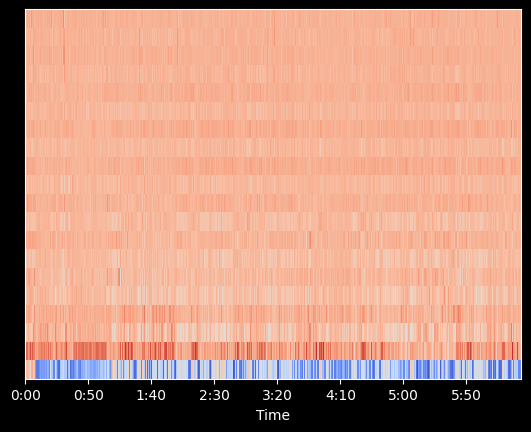

In [ ]:
# Получение из аудиофайлов массивов мел-частотных спектральных коэффициентов
#
SR = 8000 # Sample Rate - Частота дискетизации исходного звукового материала (звонки клиентов)
for au_nm in df_hl_pre_tr['Аудиофайл']:
  # загрузка аудио
  y, sr = librosa.load(WAV_PAVEL_HL+'/'+au_nm)
  print('Сформировано Librosa:')
  print(f'Частота дискретизации: {sr}')
  print(f'Значения амплитуды: \n{y[0:30]}...')
  au = librosa.resample(y, orig_sr=sr, target_sr=SR)
  # mfccs = librosa.feature.mfcc(au, sr=8000)
  au_mfcc = librosa.feature.mfcc(y=au, sr=SR) #, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
  print(f'\nВернём исходную частоту дискетизации {SR}')
  print(f'Размерность данных mfcc: {au_mfcc.shape}\n')
  librosa.display.specshow(au_mfcc, sr=SR, x_axis='time') # Отобразим спектрограммы
  plt.show() # Выведим график

  break

- Размер аудио для Частота дискретизации: 22050

In [ ]:
y.shape

(8679539,)

In [ ]:
y[0:50]

array([ 0.03524601,  0.0196627 , -0.01259354, -0.02219594, -0.00459786,
        0.02889049,  0.0539081 ,  0.04772474,  0.00936679, -0.0386662 ,
       -0.0654349 , -0.05282585, -0.00806242,  0.04090229,  0.06333575,
        0.04492296, -0.00351329, -0.05210023, -0.06839287, -0.03474725,
        0.04252264,  0.13660167,  0.2140904 ,  0.2517149 ,  0.24645343,
        0.21332207,  0.17264228,  0.1356462 ,  0.09860406,  0.04959485,
       -0.0174801 , -0.09287018, -0.1534909 , -0.17708862, -0.1581586 ,
       -0.11411999, -0.07717929, -0.07727423, -0.12705816, -0.21752432,
       -0.3252248 , -0.42509982, -0.50103533, -0.5493741 , -0.57546955,
       -0.5867205 , -0.58631426, -0.570832  , -0.5329257 , -0.4678526 ],
      dtype=float32)

- Размер аудио для Частота дискретизации: 8000 (исходная частота телефонных звонков)

In [ ]:
au.shape

(3149040,)

In [ ]:
au[31490-100:31490]

array([ 0.10002638,  0.31430745,  0.0531496 ,  0.04494114,  0.00261786,
       -0.25013256, -0.12996377, -0.2393817 , -0.3398186 , -0.29883692,
       -0.27420443, -0.17195958, -0.24173413, -0.1553862 , -0.16459264,
       -0.26562187, -0.13786922, -0.28930882, -0.28723988, -0.18189906,
       -0.3355978 , -0.24302122, -0.17112103, -0.13009796, -0.05408197,
       -0.10597228, -0.02071647, -0.00500187, -0.01476541,  0.03994644,
        0.02536204,  0.08060218,  0.0780534 ,  0.0848115 ,  0.10200407,
        0.0745092 ,  0.14098193,  0.09544329,  0.04697571,  0.09858975,
        0.1309555 ,  0.15921149,  0.10174613,  0.09301563,  0.12967686,
        0.16858914,  0.13350372,  0.032102  ,  0.18325001,  0.16364002,
        0.07224062,  0.21881445,  0.10223603,  0.14297582,  0.23474199,
        0.12166208,  0.25288498,  0.1850524 ,  0.19226484,  0.2862348 ,
        0.08324908,  0.14071694,  0.08555575,  0.04164824,  0.11534582,
       -0.05100735,  0.14250799,  0.06881645, -0.12029826,  0.12

In [ ]:
Audio(data=au, rate=8000)

In [ ]:
au[0:50]

array([ 0.01992825, -0.01547276,  0.04058935, -0.00096764, -0.05424361,
        0.06351395, -0.03315656, -0.01469555,  0.21634245,  0.22134387,
        0.11534262, -0.04153595, -0.17689262, -0.08178998, -0.17616826,
       -0.4548669 , -0.5765532 , -0.57492995, -0.41534784, -0.18997611,
       -0.17371881, -0.04943362,  0.26487792,  0.2254416 ,  0.08848313,
        0.15696786,  0.1290372 ,  0.05122405,  0.02184066, -0.05028044,
       -0.02397121, -0.03436214, -0.23525953, -0.21335849,  0.01589322,
        0.198211  ,  0.41578704,  0.3427416 ,  0.22788972,  0.45615   ,
        0.41488886,  0.17283052,  0.23668315,  0.2817772 ,  0.13936995,
       -0.01475618, -0.17604376, -0.20300522, -0.19439736, -0.34033725],
      dtype=float32)

In [ ]:
np.sctypes

{'int': [numpy.int8, numpy.int16, numpy.int32, numpy.int64],
 'uint': [numpy.uint8, numpy.uint16, numpy.uint32, numpy.uint64],
 'float': [numpy.float16, numpy.float32, numpy.float64, numpy.float128],
 'complex': [numpy.complex64, numpy.complex128, numpy.complex256],
 'others': [bool, object, bytes, str, numpy.void]}

In [ ]:
au_mfcc[0:19, 0:30]

array([[ 1.62883720e+01,  4.36278343e+01, -3.16483688e+00,
        -2.93201122e+01, -1.58452797e+01, -3.32513924e+01,
        -6.93733063e+01, -1.02280960e+02, -1.10221527e+02,
        -1.36865433e+02, -1.75408646e+02, -6.12795601e+01,
        -4.71943045e+00, -1.32937899e+01, -2.55427971e+01,
        -2.35444679e+01, -2.59511452e+01, -2.74803715e+01,
        -4.28327065e+01, -1.66518764e+01, -2.79036121e+01,
        -6.52565918e+01, -6.55387344e+01, -3.85676765e+01,
        -3.00070496e+01, -1.80129490e+01, -2.50968494e+01,
        -1.87104530e+01,  1.91974068e+01,  1.46769118e+00],
       [ 4.75521278e+01,  1.45190411e+01,  2.74694920e-01,
         4.06881065e+01,  8.40074921e+01,  1.00473122e+02,
         6.39793472e+01,  3.27385139e+01,  5.73437424e+01,
         6.68916626e+01,  5.48090668e+01,  1.15540108e+02,
         1.26624405e+02,  1.32981461e+02,  1.54752304e+02,
         1.23914581e+02,  9.56389923e+01,  1.03259720e+02,
         9.80090714e+01,  5.96457863e+01,  4.50880051e+

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:259: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(



Средние значения:
[-255.99297     43.332832   -27.787687     1.8235704  -33.09697
  -14.514231   -27.212166    -7.4719048  -21.678143    -2.996838
  -15.150218     3.8336635  -14.697465     3.8195596  -12.724368
    1.6966163   -7.9263673   -0.7035871   -4.934695    -1.3729584]

Cреднеквадратичное отклонение:
[13420.009     2931.1755    1578.5468     598.7941     638.87213
   398.68823    406.03833    270.65616    327.61368    187.8849
   165.86821    150.91069    153.39615    138.54156    146.89006
   118.56495    132.19478     98.55938    122.223785    97.15663 ]


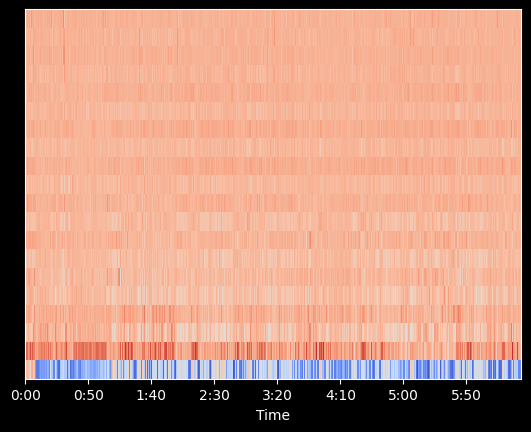

In [ ]:
# Нормируем Мел коэффициенты
au_mfcc_norm = sklearn.preprocessing.scale(au_mfcc, axis=1)
# Выводим среднее значение
# print(au_mfcc_norm.mean(axis=1))
print(f'\nСредние значения:\n{au_mfcc.mean(axis=1)}')
# Выводим среднеквадратичное отклонение
# print(au_mfcc_norm.var(axis=1))
print(f'\nCреднеквадратичное отклонение:\n{au_mfcc.var(axis=1)}')
# Отображаем нормированные коэффициенты
# librosa.display.specshow(au_mfcc_norm, sr=SR, x_axis='time') # Отобразим спектрограммы
librosa.display.specshow(au_mfcc, sr=SR, x_axis='time') # Отобразим спектрограммы
plt.show() # выведим график

In [ ]:
chroma=librosa.feature.chroma_cens(y=y_harmonic, sr=sr)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chroma,y_axis='chroma', x_axis='time')
plt.colorbar()